In [14]:
import json, os, random, time, urllib.request
from typing import Dict, List, Tuple

import psutil
import matplotlib.pyplot as plt

urlPodaci = (
    "https://raw.githubusercontent.com/dwyl/english-words/"
    "master/words_dictionary.json"
)
datotekaPodaci = "words_dictionary.json"

In [15]:
def preuzmiSkupAkoNedostaje() -> None:
    if os.path.exists(datotekaPodaci):
        return
    print("Preuzimanje skupa podataka…")
    urllib.request.urlretrieve(urlPodaci, datotekaPodaci)
    print("Preuzeto.")

preuzmiSkupAkoNedostaje()

In [16]:
class TrieCvor:
    __slots__ = ("djeca", "jeKraj")

    def __init__(self):
        self.djeca: Dict[str, "TrieCvor"] = {}
        self.jeKraj: bool = False

class Trie:
    __slots__ = ("korijen",)

    def __init__(self):
        self.korijen = TrieCvor()

    def ubaci(self, rijec: str) -> None:
        cvor = self.korijen
        for znak in rijec:
            cvor = cvor.djeca.setdefault(znak, TrieCvor())
        cvor.jeKraj = True

    def sadrzi(self, rijec: str) -> bool:
        cvor = self.korijen
        for znak in rijec:
            cvor = cvor.djeca.get(znak)
            if cvor is None:
                return False
        return cvor.jeKraj

In [20]:
proces = psutil.Process(os.getpid())

def memorijaMb() -> float:
    return proces.memory_info().rss / 1024 / 1024


def izgradiTrie(rijeci: List[str]) -> Trie:
    trieStablo = Trie()
    for r in rijeci:
        trieStablo.ubaci(r)
    return trieStablo


def mjeriIzgradnju(naziv: str, graditelj) -> Tuple[object, float]:
    memPrije = memorijaMb()
    start = time.perf_counter()
    objekat = graditelj()
    vrijeme = time.perf_counter() - start
    deltMem = memorijaMb() - memPrije
    print(f"{naziv:<9} | izgradnja {vrijeme:6.3f} s | +{deltMem:7.1f} MB")
    return objekat, vrijeme


def mjeriUpite(naziv: str, func, uzorci: List[str]) -> float:
    start = time.perf_counter()
    for r in uzorci:
        func(r)
    ukupno = time.perf_counter() - start
    print(f"{naziv:<9} | 1k upita {ukupno:6.3f} s | prosjek {(ukupno/len(uzorci))*1e6:8.2f} ms")
    return ukupno

In [21]:
print("Učitavam riječi…")
with open(datotekaPodaci, "r", encoding="utf-8") as fajl:
    rijeci = list(json.load(fajl).keys())
print(f"Ukupno riječi: {len(rijeci):,}")

random.seed(0)
uzorci = random.sample(rijeci, 1_000)

trieStablo, vrijemeTrieIzgradnja = mjeriIzgradnju("Trie", lambda: izgradiTrie(rijeci))
hashSkup, vrijemeSetIzgradnja = mjeriIzgradnju("HashSkup", lambda: set(rijeci))
listaRijeci, vrijemeListaIzgradnja = mjeriIzgradnju("Lista", lambda: list(rijeci))

print("\nMjerenje upita…")
vrijemeTrieUpiti = mjeriUpite("Trie", trieStablo.sadrzi, uzorci)
vrijemeSetUpiti = mjeriUpite("HashSkup", lambda r: r in hashSkup, uzorci)
vrijemeListaUpiti = mjeriUpite("Lista", lambda r: r in listaRijeci, uzorci)


Učitavam riječi…
Ukupno riječi: 370,100
Trie      | izgradnja  3.064 s | +  170.9 MB
HashSkup  | izgradnja  0.035 s | +    0.0 MB
Lista     | izgradnja  0.003 s | +    0.0 MB

Mjerenje upita…
Trie      | 1k upita  0.004 s | prosjek     3.85 ms
HashSkup  | 1k upita  0.001 s | prosjek     0.50 ms
Lista     | 1k upita  3.449 s | prosjek  3448.80 ms


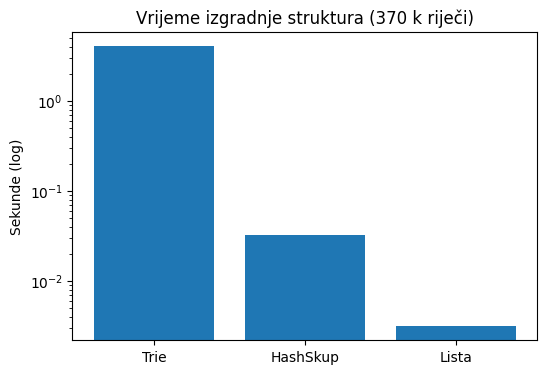

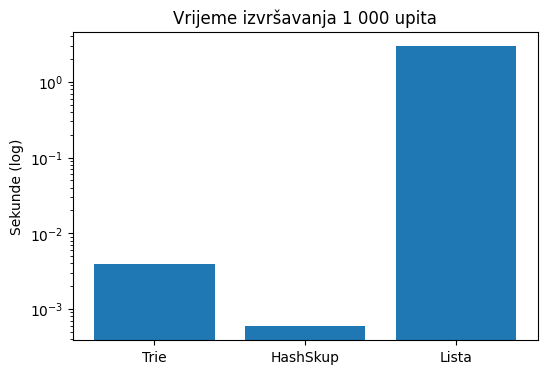

In [19]:
strukture = ["Trie", "HashSkup", "Lista"]

plt.figure(figsize=(6, 4))
plt.bar(strukture,
        [vrijemeTrieIzgradnja, vrijemeSetIzgradnja, vrijemeListaIzgradnja])
plt.ylabel("Sekunde (log)")
plt.title("Vrijeme izgradnje struktura (370 k riječi)")
plt.yscale("log")

plt.figure(figsize=(6, 4))
plt.bar(strukture,
        [vrijemeTrieUpiti, vrijemeSetUpiti, vrijemeListaUpiti])
plt.ylabel("Sekunde (log)")
plt.title("Vrijeme izvršavanja 1 000 upita")
plt.yscale("log")
plt.show()

Učitavam riječi…
Ukupno riječi: 370,100

=== Prefiks 'auto' ===
Lista     :  38781.84 µs | pronađeno = 641
HashSkup  : 149451.89 µs | pronađeno = 641
Trie      :   1485.51 µs | pronađeno = 641

=== Zauzeće memorije (MB) ===
Lista     :     0.0 MB
HashSkup  :    15.7 MB
Trie      :   -23.1 MB


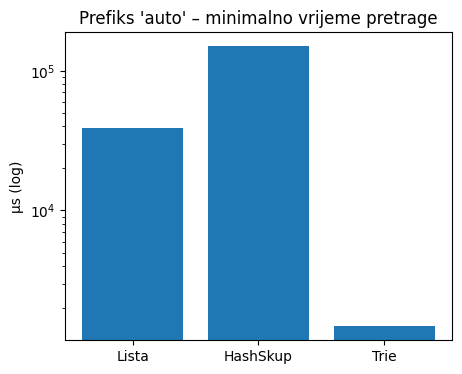

In [22]:
!pip install -q psutil matplotlib

import json
import os
import time
import urllib.request
from typing import Dict, List

import matplotlib.pyplot as plt
import psutil

url_podaci = (
    "https://raw.githubusercontent.com/dwyl/english-words/"
    "master/words_dictionary.json"
)
ime_fajla = "words_dictionary.json"
prefiks_test = "auto"
ponavljanja = 3

proces = psutil.Process(os.getpid())


def rss_mb() -> float:
    """Vrati RSS procesa u MB."""
    return proces.memory_info().rss / 1024 / 1024


class TrieCvor:
    __slots__ = ("djeca", "je_kraj")

    def __init__(self):
        self.djeca: Dict[str, "TrieCvor"] = {}
        self.je_kraj: bool = False


class Trie:
    def __init__(self):
        self.korijen = TrieCvor()

    def ubaci(self, rijec: str) -> None:
        cvor = self.korijen
        for znak in rijec:
            cvor = cvor.djeca.setdefault(znak, TrieCvor())
        cvor.je_kraj = True

    def broj_prefiks(self, prefiks: str) -> int:
        cvor = self.korijen
        for znak in prefiks:
            cvor = cvor.djeca.get(znak)
            if cvor is None:
                return 0
        return self._brojanje(cvor)

    def _brojanje(self, cvor: "TrieCvor") -> int:
        brojac = 1 if cvor.je_kraj else 0
        for dijete in cvor.djeca.values():
            brojac += self._brojanje(dijete)
        return brojac


if not os.path.exists(ime_fajla):
    print("Preuzimanje words_dictionary.json…")
    urllib.request.urlretrieve(url_podaci, ime_fajla)

print("Učitavam riječi…")
with open(ime_fajla, "r", encoding="utf-8") as f:
    rijeci: List[str] = list(json.load(f).keys())
print(f"Ukupno riječi: {len(rijeci):,}")


rez_mem: Dict[str, float] = {}

# Lista
mem0 = rss_mb()
lista_rijeci = rijeci
rez_mem["Lista"] = rss_mb() - mem0

# Hash skup
mem0 = rss_mb()
hash_skup = set(rijeci)
rez_mem["HashSkup"] = rss_mb() - mem0

# Trie
mem0 = rss_mb()
trie_stablo = Trie()
for w in rijeci:
    trie_stablo.ubaci(w)
rez_mem["Trie"] = rss_mb() - mem0



def pretraga_lista(pref: str) -> int:
    return sum(1 for w in lista_rijeci if w.startswith(pref))


def pretraga_set(pref: str) -> int:
    return sum(1 for w in hash_skup if w.startswith(pref))


def pretraga_trie(pref: str) -> int:
    return trie_stablo.broj_prefiks(pref)

funkcije = {
    "Lista": pretraga_lista,
    "HashSkup": pretraga_set,
    "Trie": pretraga_trie,
}


rez_vrijeme: Dict[str, float] = {}
rez_broj: Dict[str, int] = {}

for naziv, fn in funkcije.items():
    total = 0.0
    for _ in range(ponavljanja):
        t0 = time.perf_counter()
        k = fn(prefiks_test)
        total += time.perf_counter() - t0
    rez_vrijeme[naziv] = (total / ponavljanja) * 1e6  # µs
    rez_broj[naziv] = k

print(f"\n=== Prefiks '{prefiks_test}' ===")
for naziv in funkcije:
    print(f"{naziv:<10}: {rez_vrijeme[naziv]:9.2f} µs | pronađeno = {rez_broj[naziv]}")

print("\n=== Zauzeće memorije (MB) ===")
for naziv, mb in rez_mem.items():
    print(f"{naziv:<10}: {mb:7.1f} MB")

plt.figure(figsize=(5, 4))
plt.bar(rez_vrijeme.keys(), rez_vrijeme.values())
plt.yscale("log")
plt.ylabel("µs (log)")
plt.title(f"Prefiks '{prefiks_test}' – minimalno vrijeme pretrage")
plt.show()
